In [1]:
import os
from os.path import join
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

import cv2
from PIL import Image
import matplotlib.pyplot as plt

import gc
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, ConcatDataset, DataLoader
import torchvision.transforms as T
import albumentations as A
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")


# Control Randomness
import random
random_seed = 7
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

# EDA & Cleaning

In [ ]:
df=pd.read_pickle("LSWMD.pkl")

def removebrackets(array):
    if array.shape == (1, 1):
        return "".join(array[0])
    elif array.shape == (0, 0):
        return None
        
df.rename(columns = {'trianTestLabel':'TrainTestLabel'}, inplace = 'True')
df['TrainTestLabel'] = df['TrainTestLabel'].apply(removebrackets)
df['failureType'] = df['failureType'].apply(removebrackets)

In [3]:
df.sample(10)

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType
489317,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,...",710.0,lot30277,11.0,None,None
604268,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot38064,16.0,None,None
582932,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",846.0,lot36387,15.0,None,None
314398,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4143.0,lot19167,25.0,None,None
584221,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",846.0,lot36447,19.0,None,None
13395,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",924.0,lot2114,13.0,None,None
636974,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",712.0,lot40093,22.0,None,None
518070,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",515.0,lot32396,20.0,None,None
252155,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1,...",518.0,lot15639,19.0,Training,none
695635,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1,...",736.0,lot42848,5.0,None,None


In [4]:
df.isna().sum()

waferMap               0
dieSize                0
lotName                0
waferIndex             0
TrainTestLabel    638507
failureType       638507
dtype: int64

In [5]:
df_ = df.TrainTestLabel.dropna()
# df_ = df_.failureType.dropna()
df_

0         Training
1         Training
2         Training
3         Training
4         Training
            ...   
811450        Test
811451        Test
811452        Test
811453        Test
811454        Test
Name: TrainTestLabel, Length: 172950, dtype: object

* The dataset were collected from **47,543 lots** in real-world fab. However, **47,543 lots x 25 wafer/lot =1,157,325 wafer maps** is larger than **811,457 wafer maps**. 

* Let's see what happened. 

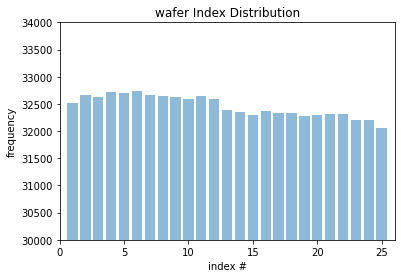

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0], uni_Index[1], align='center', alpha=0.5)
plt.title("wafer Index Distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

In [7]:
df = df.drop(['waferIndex'], axis = 1)

* We can not get much information from the wafer map column but we can see the die size for each instance is different. 

* We create a new variable **'waferMapDim'** for wafer map dim checking.

In [8]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0, dim1
    
df['waferMapDim']=df.waferMap.apply(find_dim)

In [9]:
df.sample(5)

,waferMap,dieSize,lotName,TrainTestLabel,failureType,waferMapDim
319117,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1534.0,lot19358,None,None,"(45, 43)"
476932,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot29465,None,None,"(49, 39)"
358138,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2393.0,lot21433,None,None,"(52, 59)"
211084,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",14116.0,lot13467,None,None,"(212, 84)"
373190,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",592.0,lot22287,None,None,"(29, 27)"


In [10]:
df.shape[0]
# failureType: 811457 -> 172950

811457

In [11]:
df

,waferMap,dieSize,lotName,TrainTestLabel,failureType,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)"
...,...,...,...,...,...,...
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,Test,Edge-Ring,"(26, 30)"
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,Test,Edge-Loc,"(26, 30)"
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,Test,Edge-Ring,"(26, 30)"
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,None,None,"(26, 30)"


In [12]:
df_ = df.dropna(subset=['failureType'])

In [13]:
df_

,waferMap,dieSize,lotName,TrainTestLabel,failureType,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)"
...,...,...,...,...,...,...
811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,Test,Edge-Loc,"(26, 30)"
811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,Test,Edge-Loc,"(26, 30)"
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,Test,Edge-Ring,"(26, 30)"
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,Test,Edge-Loc,"(26, 30)"


In [14]:
max(df_.waferMapDim), min(df_.waferMapDim)

((212, 84), (15, 3))

In [15]:
uni_waferDim=np.unique(df_.waferMapDim, return_counts=True)
uni_waferDim[0].shape[0]
# 632개의 서로다른 Wafer map size 가 존재.

346

In [16]:
df_.groupby("waferMapDim").size().sort_values(ascending=False)[:20]

waferMapDim
(25, 27)    18781
(26, 26)    14366
(30, 34)    12400
(29, 26)    11751
(27, 25)    10682
(39, 37)    10173
(33, 29)     8125
(42, 44)     6724
(44, 41)     6134
(41, 33)     5091
(35, 31)     4331
(25, 26)     4174
(41, 38)     4152
(33, 37)     3729
(29, 27)     2872
(45, 42)     2648
(43, 44)     2578
(41, 40)     2572
(41, 45)     2313
(38, 36)     2127
dtype: int64

* The dimension of wafer map, or saying the **image size** are not always the same. We noticed that there are **632** different size for our wafer map. 

* For this reason, we must do **data tranformation** (feature extraction) to **make input the same dim** and the method will be introduced in the following section.

>**Missing value check**
* Do not be afraid to handle so large dataset. When you look into the dataset you may notice quite number of data are useless due to **missing values**.

* Do missing value check is an important part during data preparing process. Since we only interested in wafer with patterns, we may remove those data without failure type labels. 

In [17]:
df['failureNum']=df.failureType
df['trainTestNum']=df.TrainTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [18]:
df

,waferMap,dieSize,lotName,TrainTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
...,...,...,...,...,...,...,...,...
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,Test,Edge-Ring,"(26, 30)",3.0,1.0
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,Test,Edge-Loc,"(26, 30)",2.0,1.0
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,Test,Edge-Ring,"(26, 30)",3.0,1.0
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,None,None,"(26, 30)",NaN,NaN


In [19]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(172950, 25519, 147431)

In [20]:
df_withlabel

,index,waferMap,dieSize,lotName,TrainTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
4,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
...,...,...,...,...,...,...,...,...,...
172945,811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,Test,Edge-Loc,"(26, 30)",2.0,1.0
172946,811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,Test,Edge-Loc,"(26, 30)",2.0,1.0
172947,811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,Test,Edge-Ring,"(26, 30)",3.0,1.0
172948,811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,Test,Edge-Loc,"(26, 30)",2.0,1.0


In [21]:
df_withpattern
# none 제거 버전

,index,waferMap,dieSize,lotName,TrainTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,Loc,"(45, 48)",4.0,0.0
1,36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,Training,Edge-Loc,"(53, 58)",2.0,0.0
2,37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,Training,Edge-Loc,"(53, 58)",2.0,0.0
3,38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,Training,Edge-Loc,"(53, 58)",2.0,0.0
4,39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,Training,Edge-Loc,"(53, 58)",2.0,0.0
...,...,...,...,...,...,...,...,...,...
25514,811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,Test,Edge-Loc,"(26, 30)",2.0,1.0
25515,811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,Test,Edge-Loc,"(26, 30)",2.0,1.0
25516,811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,Test,Edge-Ring,"(26, 30)",3.0,1.0
25517,811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,Test,Edge-Loc,"(26, 30)",2.0,1.0


In [22]:
df_nonpattern
# failuretype: none

,waferMap,dieSize,lotName,TrainTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
...,...,...,...,...,...,...,...,...
811438,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,Test,none,"(26, 30)",8.0,1.0
811439,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,Test,none,"(26, 30)",8.0,1.0
811442,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,...",600.0,lot47542,Test,none,"(26, 30)",8.0,1.0
811445,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,Test,none,"(26, 30)",8.0,1.0


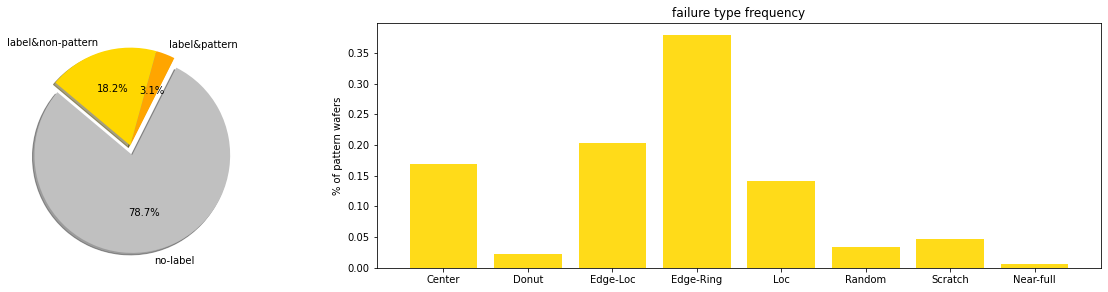

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
no_wafers=[df.shape[0]-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['silver', 'orange', 'gold']
explode = (0.1, 0, 0)  # explode 1st slice
labels = ['no-label','label&pattern','label&non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='gold', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

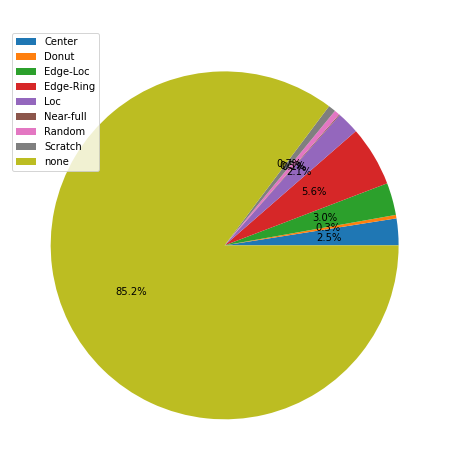

In [24]:
# with labeled - failuretype
label = df_withlabel.failureType.values

plt.figure(figsize=(8, 8))
labels = np.unique(label, return_counts=True)[0]
counts = np.unique(label, return_counts=True)[1]

pie = plt.pie(x = counts, labels=labels, autopct = "%.1f%%")
_, texts, autotexts =pie
for items in texts:
    items.set_color('white') 
    items.set_fontsize('10')
for items in autotexts:
    items.set_fontsize('10')
plt.title('failureType', color = 'white', fontsize = 20)
plt.legend()
plt.show()

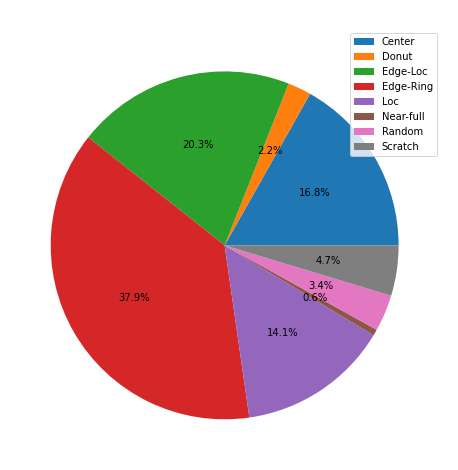

In [25]:
label = df_withpattern.failureType.values

plt.figure(figsize=(8, 8))
labels = np.unique(label, return_counts=True)[0]
counts = np.unique(label, return_counts=True)[1]

pie = plt.pie(x = counts, labels=labels, autopct = "%.1f%%")
_, texts, autotexts =pie
for items in texts:
    items.set_color('white') 
    items.set_fontsize('10')
for items in autotexts:
    items.set_fontsize('10')
plt.title('failureType', color = 'white', fontsize = 20)
plt.legend()
plt.show()

In [26]:
df_withpattern.failureType.value_counts()

Edge-Ring    9680
Edge-Loc     5189
Center       4294
Loc          3593
Scratch      1193
Random        866
Donut         555
Near-full     149
Name: failureType, dtype: int64

In [27]:
# None 클래스 Undersampling
none = df_withlabel.loc[(df_withlabel.failureType == 'none'),:].sample(10000)
df_withlabel.drop(df_withlabel[df_withlabel.failureType == 'none'].index, inplace = True)
print(none.shape)
print(df_withlabel.shape)

df_withlabel_new = pd.concat([df_withlabel, none], ignore_index=True)
df_withlabel_new.shape

(10000, 9)
(25519, 9)


(35519, 9)

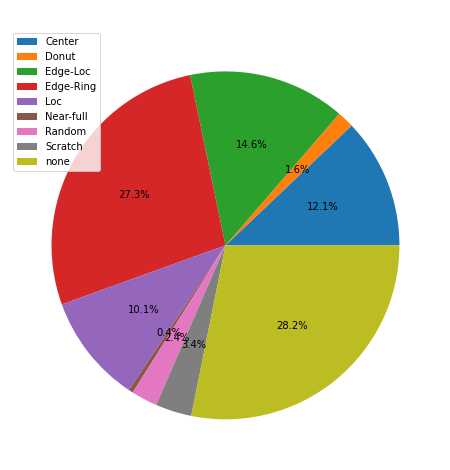

In [30]:
label = df_withlabel_new.failureType.values

plt.figure(figsize=(8, 8))
labels = np.unique(label, return_counts=True)[0]
counts = np.unique(label, return_counts=True)[1]

pie = plt.pie(x = counts, labels=labels, autopct = "%.1f%%")
_, texts, autotexts =pie
for items in texts:
    items.set_color('white') 
    items.set_fontsize('10')
for items in autotexts:
    items.set_fontsize('10')
plt.title('failureType', color = 'white', fontsize = 20)
plt.legend()
plt.show()

In [29]:
df_withlabel_new['failureType'].value_counts()

none         10000
Edge-Ring     9680
Edge-Loc      5189
Center        4294
Loc           3593
Scratch       1193
Random         866
Donut          555
Near-full      149
Name: failureType, dtype: int64

In [ ]:
df_withpattern.waferMapDim[0][0]

In [ ]:
def find_size(x):
    w = x[0]
    h = x[1]
    return np.sqrt(w*h)
    
df_withlabel['wafermaplen'] = df_withlabel.waferMapDim.apply(find_size)

In [ ]:
print(df_withlabel.wafermaplen.median())
print(df_withlabel.wafermaplen.mean())

In [ ]:
plt.hist(df_withlabel.wafermaplen, bins=20)
plt.show()

## Visualize

In [ ]:
fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(20, 20))
ax = ax.ravel(order='C')
for i in range(100):
    img = df_withlabel.waferMap[i]
    ax[i].imshow(img)
    ax[i].set_title(df_withlabel.failureType[i], fontsize=10)
    ax[i].set_xlabel(df_withlabel.index[i], fontsize=8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

In [ ]:
x = [0,1,2,3,4,5,6,7,8]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full','none']

for k in x:
    fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(18, 12))
    ax = ax.ravel(order='C')
    for j in [k]:
        img = df_withlabel.waferMap[df_withlabel.failureType==labels2[j]]
        for i in range(10):
            ax[i].imshow(img[img.index[i]])
            ax[i].set_title(df_withlabel.failureType[img.index[i]], fontsize=10)
            ax[i].set_xlabel(df_withlabel.index[img.index[i]], fontsize=10)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    plt.tight_layout()
    plt.show() 

In [ ]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

#ind_def = {'Center': 9, 'Donut': 340, 'Edge-Loc': 3, 'Edge-Ring': 16, 'Loc': 0, 'Random': 25,  'Scratch': 84, 'Near-full': 37}
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withpattern.waferMap[x[i]]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[x[i]],fontsize=24)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

In [ ]:
df_withlabel.waferMap.values[0]

In [ ]:
df_withlabel.failureNum.values

In [31]:
X = df_withlabel_new.waferMap.values
y = df_withlabel_new.failureNum.values
assert X.shape[0] == y.shape[0]

In [33]:
df_withlabel_new.failureNum.unique()

array([4., 2., 0., 3., 6., 5., 7., 1., 8.])

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val)

# train, val, test = 0.7, 0.15, 0.15

In [36]:
# torch.save(X_train, 'Data/X_train_new.pt')
# torch.save(X_val, 'Data/X_val_new.pt')
# torch.save(X_test, 'Data/X_test_new.pt')
# torch.save(y_train, 'Data/y_train_new.pt')
# torch.save(y_val, 'Data/y_val_new.pt')
# torch.save(y_test, 'Data/y_test_new.pt')

# Config

In [3]:
# Load
X_train = torch.load('Data/X_train_new.pt')
X_val = torch.load('Data/X_val_new.pt')
X_test = torch.load('Data/X_test_new.pt')
y_train = torch.load('Data/y_train_new.pt')
y_val = torch.load('Data/y_val_new.pt')
y_test = torch.load('Data/y_test_new.pt')

In [4]:
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_VAL = 512
BATCH_SIZE_TEST = 512

RE_SIZE = 96
INPUT_CH = 1    # Must be 1
NUM_CLASSES = 9
IS_PRETRAINED = False
LEARNING_RATE = 1e-4
EPOCHS = 50

save_name = f'resnet50_batch{BATCH_SIZE_TRAIN}_baseline'
save_path = f'models/{save_name}.pt'
device = torch.device("cuda:0")
print(save_name, save_path)

resnet50_batch32_baseline models/resnet50_batch32_baseline.pt


# Dataset

In [5]:
# temp_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
# data = next(iter(temp_loader))

# mean = data['img'][:, 0].float().mean().numpy()
# print(mean)

In [6]:
from albumentations.pytorch.transforms import ToTensorV2
from utils import get_transforms, display_aug
# Transforms and Dataset

class WaferDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        assert len(self.X) == len(self.y)
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        # X = self.df.waferMap.values[idx]
        # y = self.df.failureNum.values[idx].int()

        if self.transform:
            X = self.transform(image=X)
            
        return {
            'img' : X['image'], 
            'label': y
        }

train_transform, else_transform = get_transforms(size=RE_SIZE) # Just Resize and tensorize

train_dataset = WaferDataset(X_train, y_train, transform=train_transform)
val_dataset = WaferDataset(X_val, y_val, transform=else_transform)
test_dataset = WaferDataset(X_test, y_test, transform=else_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_VAL, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False)

print(len(train_dataset), len(val_dataset), len(test_dataset))

24863 5328 5328


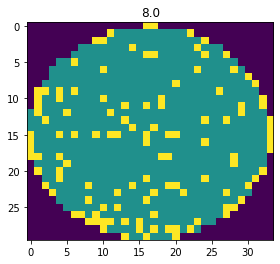

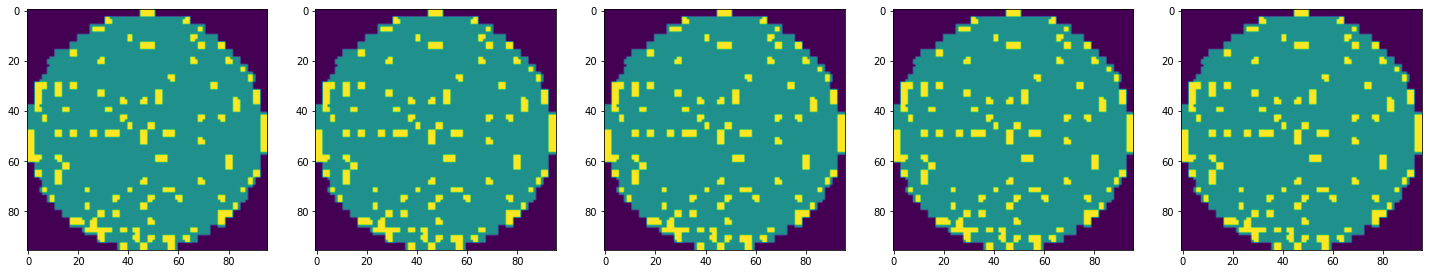

In [7]:
display_aug(imgs=X_train, transform=train_transform, labels = y_train)

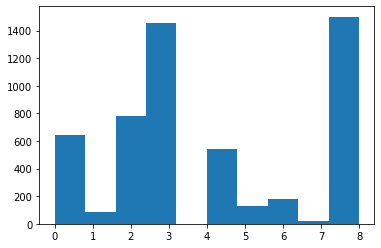

In [8]:
plt.hist(y_test)
plt.show()

# Model

In [9]:
from torchvision.models import resnet50
from torchinfo import summary

model = resnet50(pretrained=False)
model.conv1 = nn.Conv2d(INPUT_CH, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
feat = model.fc.in_features
model.fc = nn.Linear(feat, NUM_CLASSES)
# summary(model, (BATCH_SIZE_TRAIN, INPUT_CH, RE_SIZE, RE_SIZE), device='cpu')

In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau


optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(reduction='mean')
# criterion = FocalLoss(weights=weights.cuda(), gamma=2, reduce=True) # ERROR!
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, threshold=0.1, patience=5, threshold_mode='rel', verbose=True)

In [11]:
from sklearn.metrics import f1_score 

def train(model, loader, epoch, nb_epochs):
    running_loss, running_corrects, running_num = 0.0, 0, 0
    y_true, y_pred = [], []
    scaler = torch.cuda.amp.GradScaler()
    tqdm_loader = tqdm(enumerate(loader))
    model.train()
    for batch_idx, batch in tqdm_loader:
        img = batch['img'].float().cuda()
        label = batch['label'].long().cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # mixed precision + gradient clipping
        with torch.cuda.amp.autocast():
            output = model(img).cuda()
            loss = criterion(output, label)

        scaler.scale(loss).backward() 
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        scaler.step(optimizer)
        scaler.update()
        
        # # forward + backward + optimize
        # output = model(img)
        # loss = criterion(output, label)
        # loss.backward()
        # optimizer.step()
        
        # stats
        preds = torch.argmax(output, dim=1)
        correct = torch.eq(preds, label).sum()
        running_loss += loss.item() 
        running_corrects += correct
        running_num += len(label)
        
        for item in label.cpu().numpy():
            y_true.append(item)
        for item in preds.cpu().numpy():
            y_pred.append(item)
        
        tqdm_loader.set_postfix({
            'Epoch': '{}/{}'.format(epoch + 1, nb_epochs),
            'Batch' : '{}/{}'.format(batch_idx + 1, len(loader)),
            'Batch Loss': '{:06f}'.format(loss.item()),
            'Mean Loss' : '{:06f}'.format(running_loss / (batch_idx + 1)),
            'Batch ACC': '{:06f}'.format(correct / len(label)),
            'Mean ACC' : '{:06f}'.format(running_corrects / running_num)
        })

    epoch_loss = running_loss / len(loader)
    epoch_acc = running_corrects / running_num
    epoch_f1_macro = f1_score(y_true, y_pred, average='macro')
    epoch_f1_weighted = f1_score(y_true, y_pred, average='weighted')

    writer.add_scalar('Loss/Train', epoch_loss, epoch)
    writer.add_scalar('Accuracy/Train', epoch_acc, epoch)
    writer.add_scalar('F1_macro/Train', epoch_f1_macro, epoch)
    writer.add_scalar('F1_weighted/Train', epoch_f1_weighted, epoch)
    writer.add_scalar('learning_rate', optimizer.param_groups[0]["lr"], epoch)
    print(f'Train loss: {epoch_loss:.6f}, Train ACC: {epoch_acc:.6f}, F1_macro: {epoch_f1_macro:.6f}, F1_weighted: {epoch_f1_weighted:.6f} lr: {optimizer.param_groups[0]["lr"]:.6f}')
    
def evaluate(model, loader, epoch, nb_epochs):
    running_loss, running_corrects, running_num = 0.0, 0, 0
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(loader):
            img = batch['img'].float().cuda()   
            label = batch['label'].long().cuda()
            output = model(img).cuda()
            loss = criterion(output, label)

            # stats
            preds = torch.argmax(output, dim=1)
            correct = torch.eq(preds, label).sum()
            running_loss += loss.item() 
            running_corrects += correct
            running_num += len(label)

            for item in label.cpu().numpy():
                y_true.append(item)
            for item in preds.cpu().numpy():
                y_pred.append(item)

            # tqdm_loader.set_postfix({
            #     'Epoch': '{}/{}'.format(epoch + 1, nb_epochs),
            #     'Batch' : '{}/{}'.format(batch_idx + 1, len(loader)),
            #     'Batch Loss': '{:06f}'.format(loss.item()),
            #     'Mean Loss' : '{:06f}'.format(running_loss / (batch_idx + 1)),
            #     'Batch ACC': '{:06f}'.format(correct / len(label)),
            #     'Mean ACC' : '{:06f}'.format(running_corrects / running_num)
            # })

        epoch_loss = running_loss / len(loader)
        epoch_acc = running_corrects / running_num
        epoch_f1_macro = f1_score(y_true, y_pred, average='macro')
        epoch_f1_weighted = f1_score(y_true, y_pred, average='weighted')
        
        scheduler.step(epoch_loss)
        
        writer.add_scalar('Loss/Valid', epoch_loss, epoch)
        writer.add_scalar('Accuracy/Valid', epoch_acc, epoch)
        writer.add_scalar('F1_macro/Valid', epoch_f1_macro, epoch)
        writer.add_scalar('F1_weighted/Valid', epoch_f1_weighted, epoch)
        
        print(f'Valid loss: {epoch_loss:.6f}, Valid ACC: {epoch_acc:.6f}, F1_macro: {epoch_f1_macro:.6f}, F1_weighted: {epoch_f1_weighted:.6f}')
        print(f'{running_corrects}/{running_num} correct')
        
        epoch_acc = epoch_acc.detach().cpu().numpy()    # tensor->numpy
        val_acc_list.append(epoch_acc)
        val_f1_macro_list.append(epoch_f1_macro)
        val_f1_weighted_list.append(epoch_f1_weighted)
        
        if np.max(val_f1_macro_list) == val_f1_macro_list[-1]:  # 현재 모델이 성능 최댓값이면 저장 
            torch.save(model.state_dict(), save_path)   # weighted F1 기준


# Train

In [13]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir='logs/' + save_name)

val_acc_list = []
val_f1_macro_list = []
val_f1_weighted_list = []

model.to(device)

for epoch in range(EPOCHS):
    train(model, train_loader, epoch, EPOCHS)
    evaluate(model, val_loader, epoch, EPOCHS)

777it [00:47, 16.47it/s, Epoch=1/50, Batch=777/777, Batch Loss=0.315508, Mean Loss=0.542573, Batch ACC=0.903226, Mean ACC=0.815388]


Train loss: 0.542573, Train ACC: 0.815388, F1_macro: 0.672671, F1_weighted: 0.801235 lr: 0.000100
Valid loss: 0.399242, Valid ACC: 0.867117, F1_macro: 0.773966, F1_weighted: 0.862080
4620/5328 correct


777it [00:46, 16.63it/s, Epoch=2/50, Batch=777/777, Batch Loss=0.340025, Mean Loss=0.302415, Batch ACC=0.870968, Mean ACC=0.893738]


Train loss: 0.302415, Train ACC: 0.893738, F1_macro: 0.797753, F1_weighted: 0.886656 lr: 0.000100
Valid loss: 0.331201, Valid ACC: 0.889827, F1_macro: 0.815360, F1_weighted: 0.883101
4741/5328 correct


777it [00:46, 16.78it/s, Epoch=3/50, Batch=777/777, Batch Loss=0.461508, Mean Loss=0.263685, Batch ACC=0.838710, Mean ACC=0.904557]


Train loss: 0.263685, Train ACC: 0.904557, F1_macro: 0.821537, F1_weighted: 0.900613 lr: 0.000100
Valid loss: 0.385201, Valid ACC: 0.876314, F1_macro: 0.769053, F1_weighted: 0.870330
4669/5328 correct


777it [00:46, 16.65it/s, Epoch=4/50, Batch=777/777, Batch Loss=0.402268, Mean Loss=0.248891, Batch ACC=0.935484, Mean ACC=0.912400]


Train loss: 0.248891, Train ACC: 0.912400, F1_macro: 0.839850, F1_weighted: 0.909773 lr: 0.000100
Valid loss: 0.356033, Valid ACC: 0.886261, F1_macro: 0.783069, F1_weighted: 0.881094
4722/5328 correct


777it [00:46, 16.70it/s, Epoch=5/50, Batch=777/777, Batch Loss=0.245932, Mean Loss=0.213446, Batch ACC=0.903226, Mean ACC=0.925230]


Train loss: 0.213446, Train ACC: 0.925230, F1_macro: 0.861580, F1_weighted: 0.923172 lr: 0.000100
Valid loss: 0.345122, Valid ACC: 0.889452, F1_macro: 0.802135, F1_weighted: 0.890070
4739/5328 correct


777it [00:47, 16.26it/s, Epoch=6/50, Batch=777/777, Batch Loss=0.334177, Mean Loss=0.164618, Batch ACC=0.903226, Mean ACC=0.942244]


Train loss: 0.164618, Train ACC: 0.942244, F1_macro: 0.895438, F1_weighted: 0.941386 lr: 0.000100
Valid loss: 0.343736, Valid ACC: 0.897147, F1_macro: 0.835414, F1_weighted: 0.894095
4780/5328 correct


777it [00:47, 16.40it/s, Epoch=7/50, Batch=777/777, Batch Loss=0.174686, Mean Loss=0.158163, Batch ACC=0.967742, Mean ACC=0.943611]


Train loss: 0.158163, Train ACC: 0.943611, F1_macro: 0.899947, F1_weighted: 0.942823 lr: 0.000100
Valid loss: 0.375247, Valid ACC: 0.890203, F1_macro: 0.840064, F1_weighted: 0.891525
4743/5328 correct


777it [00:47, 16.27it/s, Epoch=8/50, Batch=777/777, Batch Loss=0.311744, Mean Loss=0.145856, Batch ACC=0.870968, Mean ACC=0.949564]


Train loss: 0.145856, Train ACC: 0.949564, F1_macro: 0.913969, F1_weighted: 0.949199 lr: 0.000100
Epoch     8: reducing learning rate of group 0 to 5.0000e-05.
Valid loss: 0.436476, Valid ACC: 0.869557, F1_macro: 0.749978, F1_weighted: 0.868668
4633/5328 correct


777it [00:47, 16.27it/s, Epoch=9/50, Batch=777/777, Batch Loss=0.369248, Mean Loss=0.093886, Batch ACC=0.903226, Mean ACC=0.967100]


Train loss: 0.093886, Train ACC: 0.967100, F1_macro: 0.939595, F1_weighted: 0.966968 lr: 0.000050
Valid loss: 0.397573, Valid ACC: 0.905968, F1_macro: 0.862456, F1_weighted: 0.905220
4827/5328 correct


777it [00:48, 16.18it/s, Epoch=10/50, Batch=777/777, Batch Loss=0.018527, Mean Loss=0.040945, Batch ACC=1.000000, Mean ACC=0.986486]


Train loss: 0.040945, Train ACC: 0.986486, F1_macro: 0.973683, F1_weighted: 0.986461 lr: 0.000050
Valid loss: 0.520833, Valid ACC: 0.908408, F1_macro: 0.857080, F1_weighted: 0.906522
4840/5328 correct


777it [00:48, 15.96it/s, Epoch=11/50, Batch=777/777, Batch Loss=0.000179, Mean Loss=0.052204, Batch ACC=1.000000, Mean ACC=0.984354]


Train loss: 0.052204, Train ACC: 0.984354, F1_macro: 0.968390, F1_weighted: 0.984339 lr: 0.000050
Valid loss: 0.602880, Valid ACC: 0.908971, F1_macro: 0.859921, F1_weighted: 0.906748
4843/5328 correct


777it [00:48, 16.06it/s, Epoch=12/50, Batch=777/777, Batch Loss=0.000363, Mean Loss=0.075624, Batch ACC=1.000000, Mean ACC=0.980775]


Train loss: 0.075624, Train ACC: 0.980775, F1_macro: 0.963312, F1_weighted: 0.980745 lr: 0.000050
Valid loss: 0.703582, Valid ACC: 0.902027, F1_macro: 0.853362, F1_weighted: 0.901990
4806/5328 correct


777it [00:48, 15.93it/s, Epoch=13/50, Batch=777/777, Batch Loss=0.000130, Mean Loss=0.076643, Batch ACC=1.000000, Mean ACC=0.980011]


Train loss: 0.076643, Train ACC: 0.980011, F1_macro: 0.964378, F1_weighted: 0.979972 lr: 0.000050
Valid loss: 0.730691, Valid ACC: 0.905218, F1_macro: 0.838326, F1_weighted: 0.902133
4823/5328 correct


777it [00:49, 15.79it/s, Epoch=14/50, Batch=777/777, Batch Loss=0.107669, Mean Loss=0.061293, Batch ACC=0.935484, Mean ACC=0.985119]


Train loss: 0.061293, Train ACC: 0.985119, F1_macro: 0.970673, F1_weighted: 0.985100 lr: 0.000050
Epoch    14: reducing learning rate of group 0 to 2.5000e-05.
Valid loss: 0.849912, Valid ACC: 0.902778, F1_macro: 0.848826, F1_weighted: 0.900717
4810/5328 correct


777it [00:50, 15.43it/s, Epoch=15/50, Batch=777/777, Batch Loss=0.000066, Mean Loss=0.023004, Batch ACC=1.000000, Mean ACC=0.994570]


Train loss: 0.023004, Train ACC: 0.994570, F1_macro: 0.989621, F1_weighted: 0.994565 lr: 0.000025
Valid loss: 0.857013, Valid ACC: 0.910848, F1_macro: 0.866816, F1_weighted: 0.909682
4853/5328 correct


777it [00:48, 15.95it/s, Epoch=16/50, Batch=777/777, Batch Loss=0.000001, Mean Loss=0.013590, Batch ACC=1.000000, Mean ACC=0.997104]


Train loss: 0.013590, Train ACC: 0.997104, F1_macro: 0.993458, F1_weighted: 0.997102 lr: 0.000025
Valid loss: 1.003666, Valid ACC: 0.911787, F1_macro: 0.862459, F1_weighted: 0.910450
4858/5328 correct


777it [00:48, 15.95it/s, Epoch=17/50, Batch=777/777, Batch Loss=0.000074, Mean Loss=0.009544, Batch ACC=1.000000, Mean ACC=0.997748]


Train loss: 0.009544, Train ACC: 0.997748, F1_macro: 0.996644, F1_weighted: 0.997747 lr: 0.000025
Valid loss: 1.044297, Valid ACC: 0.913101, F1_macro: 0.871224, F1_weighted: 0.911736
4865/5328 correct


777it [00:46, 16.59it/s, Epoch=18/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.008714, Batch ACC=1.000000, Mean ACC=0.998311]


Train loss: 0.008714, Train ACC: 0.998311, F1_macro: 0.996197, F1_weighted: 0.998311 lr: 0.000025
Valid loss: 1.113040, Valid ACC: 0.913476, F1_macro: 0.868061, F1_weighted: 0.911944
4867/5328 correct


777it [00:46, 16.79it/s, Epoch=19/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.006011, Batch ACC=1.000000, Mean ACC=0.998673]


Train loss: 0.006011, Train ACC: 0.998673, F1_macro: 0.996586, F1_weighted: 0.998673 lr: 0.000025
Valid loss: 1.156302, Valid ACC: 0.915728, F1_macro: 0.867079, F1_weighted: 0.914362
4879/5328 correct


777it [00:47, 16.52it/s, Epoch=20/50, Batch=777/777, Batch Loss=0.000001, Mean Loss=0.005466, Batch ACC=1.000000, Mean ACC=0.998834]


Train loss: 0.005466, Train ACC: 0.998834, F1_macro: 0.997847, F1_weighted: 0.998833 lr: 0.000025
Epoch    20: reducing learning rate of group 0 to 1.2500e-05.
Valid loss: 1.296853, Valid ACC: 0.912725, F1_macro: 0.860508, F1_weighted: 0.910011
4863/5328 correct


777it [00:47, 16.44it/s, Epoch=21/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.005663, Batch ACC=1.000000, Mean ACC=0.999236]


Train loss: 0.005663, Train ACC: 0.999236, F1_macro: 0.999115, F1_weighted: 0.999236 lr: 0.000013
Valid loss: 1.212473, Valid ACC: 0.917980, F1_macro: 0.872833, F1_weighted: 0.916138
4891/5328 correct


777it [00:47, 16.37it/s, Epoch=22/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.002468, Batch ACC=1.000000, Mean ACC=0.999718]


Train loss: 0.002468, Train ACC: 0.999718, F1_macro: 0.999729, F1_weighted: 0.999718 lr: 0.000013
Valid loss: 1.197489, Valid ACC: 0.917605, F1_macro: 0.874140, F1_weighted: 0.916213
4889/5328 correct


777it [00:46, 16.62it/s, Epoch=23/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.002863, Batch ACC=1.000000, Mean ACC=0.999477]


Train loss: 0.002863, Train ACC: 0.999477, F1_macro: 0.999235, F1_weighted: 0.999477 lr: 0.000013
Valid loss: 1.269961, Valid ACC: 0.915165, F1_macro: 0.866256, F1_weighted: 0.912197
4876/5328 correct


777it [00:46, 16.75it/s, Epoch=24/50, Batch=777/777, Batch Loss=0.126150, Mean Loss=0.002373, Batch ACC=0.967742, Mean ACC=0.999558]


Train loss: 0.002373, Train ACC: 0.999558, F1_macro: 0.999384, F1_weighted: 0.999558 lr: 0.000013
Valid loss: 1.350734, Valid ACC: 0.912725, F1_macro: 0.865949, F1_weighted: 0.910000
4863/5328 correct


777it [00:46, 16.76it/s, Epoch=25/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.002808, Batch ACC=1.000000, Mean ACC=0.999558]


Train loss: 0.002808, Train ACC: 0.999558, F1_macro: 0.999373, F1_weighted: 0.999558 lr: 0.000013
Valid loss: 1.360275, Valid ACC: 0.914039, F1_macro: 0.871744, F1_weighted: 0.912144
4870/5328 correct


777it [00:46, 16.74it/s, Epoch=26/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.001409, Batch ACC=1.000000, Mean ACC=0.999598]


Train loss: 0.001409, Train ACC: 0.999598, F1_macro: 0.999422, F1_weighted: 0.999598 lr: 0.000013
Epoch    26: reducing learning rate of group 0 to 6.2500e-06.
Valid loss: 1.340545, Valid ACC: 0.913476, F1_macro: 0.867073, F1_weighted: 0.910967
4867/5328 correct


777it [00:47, 16.21it/s, Epoch=27/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.002220, Batch ACC=1.000000, Mean ACC=0.999638]


Train loss: 0.002220, Train ACC: 0.999638, F1_macro: 0.999623, F1_weighted: 0.999638 lr: 0.000006
Valid loss: 1.337862, Valid ACC: 0.914790, F1_macro: 0.866310, F1_weighted: 0.912056
4874/5328 correct


777it [00:48, 15.94it/s, Epoch=28/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.001699, Batch ACC=1.000000, Mean ACC=0.999799]


Train loss: 0.001699, Train ACC: 0.999799, F1_macro: 0.999803, F1_weighted: 0.999799 lr: 0.000006
Valid loss: 1.266614, Valid ACC: 0.916479, F1_macro: 0.869667, F1_weighted: 0.914332
4883/5328 correct


777it [00:48, 15.86it/s, Epoch=29/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.000882, Batch ACC=1.000000, Mean ACC=0.999960]


Train loss: 0.000882, Train ACC: 0.999960, F1_macro: 0.999977, F1_weighted: 0.999960 lr: 0.000006
Valid loss: 1.297383, Valid ACC: 0.915728, F1_macro: 0.866940, F1_weighted: 0.913524
4879/5328 correct


777it [00:47, 16.24it/s, Epoch=30/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.001082, Batch ACC=1.000000, Mean ACC=0.999879]


Train loss: 0.001082, Train ACC: 0.999879, F1_macro: 0.999792, F1_weighted: 0.999879 lr: 0.000006
Valid loss: 1.291597, Valid ACC: 0.917417, F1_macro: 0.874803, F1_weighted: 0.915509
4888/5328 correct


777it [00:47, 16.23it/s, Epoch=31/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.003051, Batch ACC=1.000000, Mean ACC=0.999638]


Train loss: 0.003051, Train ACC: 0.999638, F1_macro: 0.999640, F1_weighted: 0.999638 lr: 0.000006
Valid loss: 1.299318, Valid ACC: 0.914790, F1_macro: 0.865629, F1_weighted: 0.913212
4874/5328 correct


777it [00:48, 15.92it/s, Epoch=32/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.001182, Batch ACC=1.000000, Mean ACC=0.999759]


Train loss: 0.001182, Train ACC: 0.999759, F1_macro: 0.999671, F1_weighted: 0.999759 lr: 0.000006
Epoch    32: reducing learning rate of group 0 to 3.1250e-06.
Valid loss: 1.313654, Valid ACC: 0.918356, F1_macro: 0.865621, F1_weighted: 0.915771
4893/5328 correct


777it [00:48, 15.99it/s, Epoch=33/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.001315, Batch ACC=1.000000, Mean ACC=0.999759]


Train loss: 0.001315, Train ACC: 0.999759, F1_macro: 0.999846, F1_weighted: 0.999759 lr: 0.000003
Valid loss: 1.346287, Valid ACC: 0.917793, F1_macro: 0.866215, F1_weighted: 0.915374
4890/5328 correct


777it [00:48, 16.14it/s, Epoch=34/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.001314, Batch ACC=1.000000, Mean ACC=0.999839]


Train loss: 0.001314, Train ACC: 0.999839, F1_macro: 0.999907, F1_weighted: 0.999839 lr: 0.000003
Valid loss: 1.334128, Valid ACC: 0.915728, F1_macro: 0.872966, F1_weighted: 0.913539
4879/5328 correct


777it [00:48, 16.11it/s, Epoch=35/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.001723, Batch ACC=1.000000, Mean ACC=0.999799]


Train loss: 0.001723, Train ACC: 0.999799, F1_macro: 0.999869, F1_weighted: 0.999799 lr: 0.000003
Valid loss: 1.300163, Valid ACC: 0.918168, F1_macro: 0.872516, F1_weighted: 0.916266
4892/5328 correct


777it [00:48, 16.13it/s, Epoch=36/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.000668, Batch ACC=1.000000, Mean ACC=0.999920]


Train loss: 0.000668, Train ACC: 0.999920, F1_macro: 0.999902, F1_weighted: 0.999920 lr: 0.000003
Valid loss: 1.337665, Valid ACC: 0.918356, F1_macro: 0.876625, F1_weighted: 0.916279
4893/5328 correct


777it [00:47, 16.27it/s, Epoch=37/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.001504, Batch ACC=1.000000, Mean ACC=0.999879]


Train loss: 0.001504, Train ACC: 0.999879, F1_macro: 0.999916, F1_weighted: 0.999879 lr: 0.000003
Valid loss: 1.322437, Valid ACC: 0.916854, F1_macro: 0.872279, F1_weighted: 0.914900
4885/5328 correct


777it [00:48, 16.13it/s, Epoch=38/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.001463, Batch ACC=1.000000, Mean ACC=0.999839]


Train loss: 0.001463, Train ACC: 0.999839, F1_macro: 0.999855, F1_weighted: 0.999839 lr: 0.000003
Epoch    38: reducing learning rate of group 0 to 1.5625e-06.
Valid loss: 1.327397, Valid ACC: 0.917980, F1_macro: 0.874141, F1_weighted: 0.916096
4891/5328 correct


777it [00:47, 16.45it/s, Epoch=39/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.002528, Batch ACC=1.000000, Mean ACC=0.999879]


Train loss: 0.002528, Train ACC: 0.999879, F1_macro: 0.999777, F1_weighted: 0.999879 lr: 0.000002
Valid loss: 1.321092, Valid ACC: 0.917230, F1_macro: 0.868386, F1_weighted: 0.915011
4887/5328 correct


777it [00:47, 16.41it/s, Epoch=40/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.000729, Batch ACC=1.000000, Mean ACC=0.999920]


Train loss: 0.000729, Train ACC: 0.999920, F1_macro: 0.999826, F1_weighted: 0.999920 lr: 0.000002
Valid loss: 1.326981, Valid ACC: 0.916854, F1_macro: 0.872002, F1_weighted: 0.914962
4885/5328 correct


777it [00:47, 16.21it/s, Epoch=41/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.000703, Batch ACC=1.000000, Mean ACC=0.999839]


Train loss: 0.000703, Train ACC: 0.999839, F1_macro: 0.999906, F1_weighted: 0.999839 lr: 0.000002
Valid loss: 1.295317, Valid ACC: 0.917417, F1_macro: 0.870810, F1_weighted: 0.915477
4888/5328 correct


777it [00:46, 16.58it/s, Epoch=42/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.000769, Batch ACC=1.000000, Mean ACC=0.999920]


Train loss: 0.000769, Train ACC: 0.999920, F1_macro: 0.999953, F1_weighted: 0.999920 lr: 0.000002
Valid loss: 1.273391, Valid ACC: 0.918731, F1_macro: 0.869309, F1_weighted: 0.916858
4895/5328 correct


777it [00:47, 16.31it/s, Epoch=43/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.000933, Batch ACC=1.000000, Mean ACC=0.999799]


Train loss: 0.000933, Train ACC: 0.999799, F1_macro: 0.999790, F1_weighted: 0.999799 lr: 0.000002
Valid loss: 1.303359, Valid ACC: 0.918731, F1_macro: 0.875057, F1_weighted: 0.916436
4895/5328 correct


777it [00:46, 16.57it/s, Epoch=44/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.000705, Batch ACC=1.000000, Mean ACC=0.999920]


Train loss: 0.000705, Train ACC: 0.999920, F1_macro: 0.999953, F1_weighted: 0.999920 lr: 0.000002
Epoch    44: reducing learning rate of group 0 to 7.8125e-07.
Valid loss: 1.320657, Valid ACC: 0.918356, F1_macro: 0.875031, F1_weighted: 0.916766
4893/5328 correct


777it [00:47, 16.25it/s, Epoch=45/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.000685, Batch ACC=1.000000, Mean ACC=0.999879]


Train loss: 0.000685, Train ACC: 0.999879, F1_macro: 0.999923, F1_weighted: 0.999879 lr: 0.000001
Valid loss: 1.291355, Valid ACC: 0.919294, F1_macro: 0.875545, F1_weighted: 0.917151
4898/5328 correct


777it [00:47, 16.25it/s, Epoch=46/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.001991, Batch ACC=1.000000, Mean ACC=0.999799]


Train loss: 0.001991, Train ACC: 0.999799, F1_macro: 0.999869, F1_weighted: 0.999799 lr: 0.000001
Valid loss: 1.321332, Valid ACC: 0.917980, F1_macro: 0.871255, F1_weighted: 0.915600
4891/5328 correct


777it [00:48, 16.13it/s, Epoch=47/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.000645, Batch ACC=1.000000, Mean ACC=0.999839]


Train loss: 0.000645, Train ACC: 0.999839, F1_macro: 0.999892, F1_weighted: 0.999839 lr: 0.000001
Valid loss: 1.305831, Valid ACC: 0.919107, F1_macro: 0.876463, F1_weighted: 0.917290
4897/5328 correct


777it [00:48, 15.87it/s, Epoch=48/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.001305, Batch ACC=1.000000, Mean ACC=0.999920]


Train loss: 0.001305, Train ACC: 0.999920, F1_macro: 0.999818, F1_weighted: 0.999920 lr: 0.000001
Valid loss: 1.280736, Valid ACC: 0.918919, F1_macro: 0.869771, F1_weighted: 0.917124
4896/5328 correct


777it [00:48, 16.08it/s, Epoch=49/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.001448, Batch ACC=1.000000, Mean ACC=0.999879]


Train loss: 0.001448, Train ACC: 0.999879, F1_macro: 0.999864, F1_weighted: 0.999879 lr: 0.000001
Valid loss: 1.318263, Valid ACC: 0.917980, F1_macro: 0.876553, F1_weighted: 0.916548
4891/5328 correct


777it [00:47, 16.44it/s, Epoch=50/50, Batch=777/777, Batch Loss=0.000000, Mean Loss=0.001033, Batch ACC=1.000000, Mean ACC=0.999879]


Train loss: 0.001033, Train ACC: 0.999879, F1_macro: 0.999839, F1_weighted: 0.999879 lr: 0.000001
Epoch    50: reducing learning rate of group 0 to 3.9063e-07.
Valid loss: 1.293929, Valid ACC: 0.917980, F1_macro: 0.875693, F1_weighted: 0.916066
4891/5328 correct


In [14]:
print(max(val_acc_list), max(val_f1_macro_list), max(val_f1_weighted_list))

0.9192943 0.8766246028112481 0.9172895670948131


# Test

In [15]:
def test(model, loader):
    running_loss = 0.0
    running_f1 = 0.0
    running_corrects = 0
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for idx, batch in enumerate(tqdm(loader)):
            img = batch['img'].float().to(device)
            label = batch['label'].long().to(device)

            output = model(img)
            # stats
            preds = torch.argmax(output, dim=1)
            correct = torch.eq(preds, label).sum()
            running_corrects+=correct
    
            for item in label.cpu().numpy():
                y_true.append(item)
            for item in preds.cpu().numpy():
                y_pred.append(item)

        epoch_acc = running_corrects / len(loader.dataset)
        epoch_f1_macro = f1_score(y_true, y_pred, average='macro')
        epoch_f1_weighted = f1_score(y_true, y_pred, average='weighted')
        
        print(f'{running_corrects}/{len(loader.dataset)} correct')
        print(f'Test ACC: {epoch_acc:.6f}, F1_macro: {epoch_f1_macro:.6f}, F1_weighted: {epoch_f1_weighted:.6f}')

    plt.figure(figsize=(20, 20))
    sns.heatmap(
        confusion_matrix(
            y_true,
            y_pred,
            normalize = 'true'), 
            annot=True, cmap='coolwarm'
            )
    plt.title("CONFUSION MATRIX of the test dataset", fontsize=25)
    plt.show()


100%|██████████| 11/11 [00:01<00:00, 10.48it/s]


4853/5328 correct
Test ACC: 0.910848, F1_macro: 0.854978, F1_weighted: 0.908003


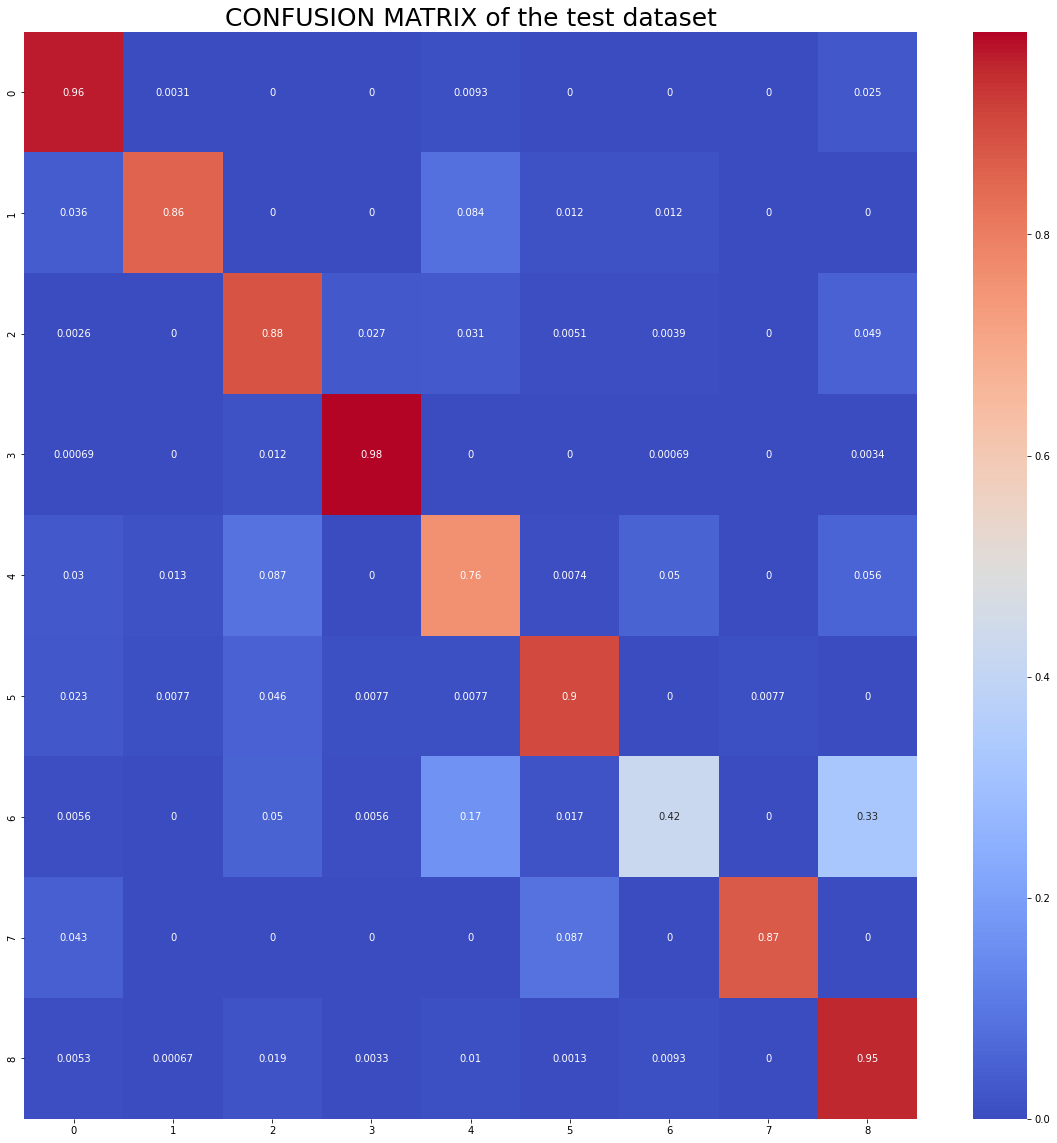

In [16]:
from torchvision.models import resnet50
import torch.nn as nn 
from sklearn.metrics import confusion_matrix

model = resnet50(pretrained=False)
model.conv1 = nn.Conv2d(INPUT_CH, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
feat = model.fc.in_features
model.fc = nn.Linear(feat, NUM_CLASSES)

# LOAD trained model 
model.load_state_dict(torch.load(save_path))
model.to(device)
test(model, test_loader)